# This notebook is for training a visual content recognition model on *Beyond Words* annotations. 
Benjamin Charles Germain Lee
(bcgl@cs.washington.edu)

Utilizing Detectron2, it finetunes a pre-trained image recognition model to put bounding boxes on Photographs, Comics/Cartoons, and Maps in historical newspaper images, while ignoring advertisements.  

This notebook makes the following assumptions:

- The newspaper-navigator repo has been cloned, so the local file structure is intact.
- The bash script for installing detectron2 (install-detectron2.sh) has been run on the machine so the detectron2 can be used.

This notebook is based on the following notebooks:

- https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
- https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/


This cell imports a bunch of the libraries needed and constructs a COCO instance using the "trainval.json" and "test.json"; essentially, this enables the model to handle the data loading using the COCO framework (this is why the data is structured in the COCO format):

In [1]:
# to display images inline
%matplotlib inline

# setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# cd into the beyond words dataset
os.chdir("./beyond_words_data")

# we now register the dataset
register_coco_instances("beyond_words_train_val", {}, "trainval_80_percent.json", "images")
register_coco_instances("beyond_words_test", {}, "test_80_percent.json", "images")
register_coco_instances("beyond_words_combined", {}, "trainval.json", "images")

This cell visualizes some examples from the training set (code for visualizing the images are from here: https://medium.com/@chengweizhang2012/how-to-train-detectron2-with-custom-coco-datasets-4d5170c9f389)

WARNING [02/13 02:33:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/13 02:33:54 d2.data.datasets.coco]: Loaded 2748 images in COCO format from trainval_80_percent.json
images/1578.jpg
images/1723.jpg
images/166.jpg
images/1061.jpg
images/2095.jpg


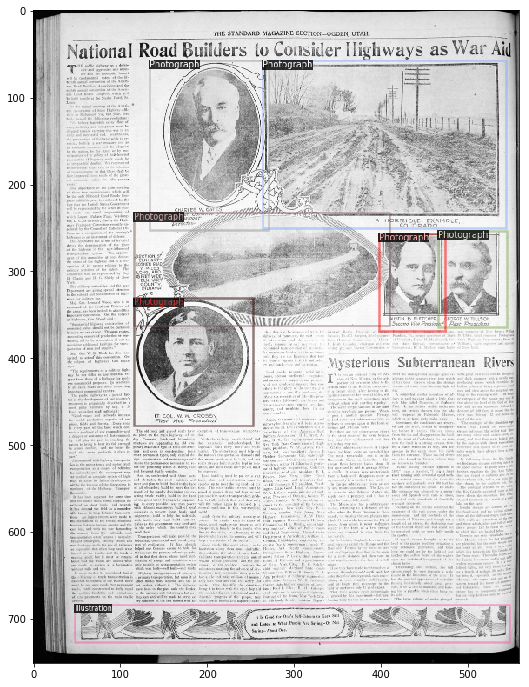

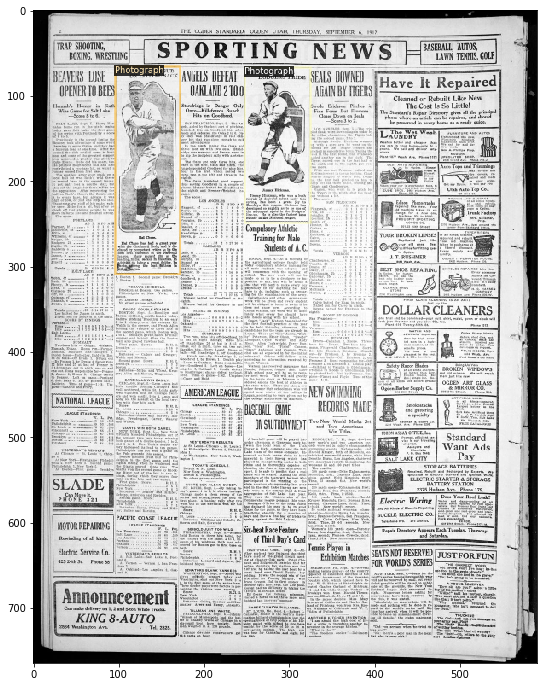

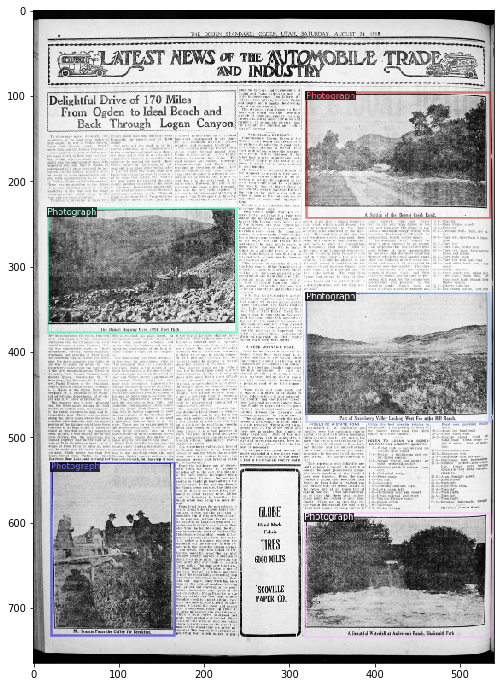

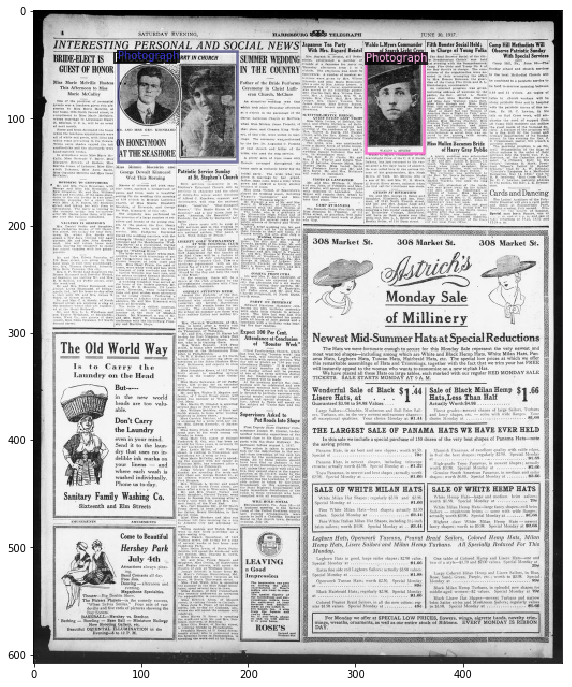

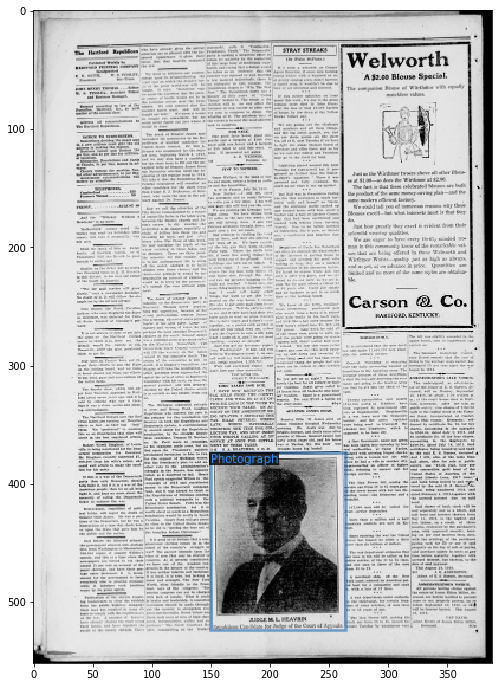

In [2]:
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# sets random seed for reproducibility
random.seed(0)

dataset_dicts = DatasetCatalog.get("beyond_words_train_val")
my_metadata = MetadataCatalog.get("beyond_words_train_val")

for d in random.sample(dataset_dicts, 5):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,12))
    plt.imshow(vis.get_image()[:, :, ::-1])


# WE COMPARE FASTER-RCNN IMPLEMENTATIONS THAT ONLY RELY ON BOUNDING BOXES
 - Can pick here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-person-keypoint-detection-baselines-with-keypoint-r-cnn


*Note*: currently, Detectron2 only supports a couple of different data augmentation techniques (ResizeShortestEdge and RandomFlip); see https://github.com/facebookresearch/Detectron/blob/master/detectron/datasets/roidb.py#L76 for more details.


First, we start with Faster_rcnn_R_50_FPN_3x and evaluate mean average precision on the held-out data (80%-20% split for train and test):


In [3]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator

cfg = get_cfg()
# loads in correct pre-trained model parameters
cfg.merge_from_file("../..//detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# loads pre-trained model weights (from Model Zoo)
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
# loads in training/val/test data using the registered COCO instance
cfg.DATASETS.TRAIN = ("beyond_words_train_val",)
cfg.DATASETS.TEST = ("beyond_words_test",)
# sets number of object classes
# (5:  "Illustration/Photograph", "Photograph", "Comics/Cartoon", "Editorial Cartoon", "Map")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

# some hyperparameters
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.SOLVER.MAX_ITER = 687 # 687 corresponds to one epoch for the training set
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4

# makes output directory for weights, etc.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# trains 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# tests
# note:  this command is quite tricky to get right (took 2 hours)
trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_test", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))

# for i in range(0, 30):

#   # trains again
#   cfg.SOLVER.MAX_ITER = 1000*(i+1)
#   trainer = DefaultTrainer(cfg) 
#   trainer.resume_or_load(resume=True)
#   trainer.train()

#   # tests again
#   trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_test", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))



[02/13 02:34:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [02/13 02:34:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/13 02:34:06 d2.data.datasets.coco]: Loaded 2748 images in COCO format from trainval_80_percent.json
[02/13 02:34:07 d2.data.build]: Removed 4 images with no usable annotations. 2744 images left.
[02/13 02:34:07 d2.data.build]: Distribution of instances among all 5 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
|  Photograph   | 3419         | Illustration  | 827          |    Map     | 66           |
| Comics/Cart.. | 915          | Editorial C.. | 237          |            |              |
|     total     | 5464         |               |              |            |              |
[02/13 02:34:07 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (6, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (6,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (20, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (20,) in the model! Skipped.


[02/13 02:34:07 d2.engine.train_loop]: Starting training from iteration 0
[02/13 02:34:51 d2.utils.events]: eta: 0:03:00  iter: 19  total_loss: 2.578  loss_cls: 1.864  loss_box_reg: 0.627  loss_rpn_cls: 0.049  loss_rpn_loc: 0.017  time: 2.2368  data_time: 0.0247  lr: 0.000005  max_mem: 4322M
[02/13 02:35:35 d2.utils.events]: eta: 0:02:14  iter: 39  total_loss: 2.431  loss_cls: 1.748  loss_box_reg: 0.595  loss_rpn_cls: 0.027  loss_rpn_loc: 0.015  time: 2.2026  data_time: 0.0109  lr: 0.000010  max_mem: 4322M
[02/13 02:36:21 d2.utils.events]: eta: 0:01:30  iter: 59  total_loss: 2.187  loss_cls: 1.560  loss_box_reg: 0.610  loss_rpn_cls: 0.031  loss_rpn_loc: 0.014  time: 2.2342  data_time: 0.0150  lr: 0.000015  max_mem: 4534M
[02/13 02:37:05 d2.utils.events]: eta: 0:00:46  iter: 79  total_loss: 1.971  loss_cls: 1.274  loss_box_reg: 0.652  loss_rpn_cls: 0.023  loss_rpn_loc: 0.013  time: 2.2332  data_time: 0.0114  lr: 0.000020  max_mem: 4534M
WARNING [02/13 02:37:53 d2.data.datasets.coco]: 
C

[02/13 02:41:41 d2.evaluation.coco_evaluation]: Note that some metrics cannot be computed.
[02/13 02:41:41 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category       | AP    | category          | AP    | category   | AP    |
|:---------------|:------|:------------------|:------|:-----------|:------|
| Photograph     | 1.308 | Illustration      | 0.011 | Map        | 0.004 |
| Comics/Cartoon | 0.000 | Editorial Cartoon | 0.002 |            |       |
[02/13 02:41:41 d2.engine.defaults]: Evaluation results for beyond_words_test in csv format:
[02/13 02:41:41 d2.evaluation.testing]: copypaste: Task: bbox
[02/13 02:41:41 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[02/13 02:41:41 d2.evaluation.testing]: copypaste: 0.2647,1.1582,0.0075,nan,0.0892,0.4706


OrderedDict([('bbox',
              {'AP': 0.26470232401081384,
               'AP50': 1.1582250984898532,
               'AP75': 0.007512115526464573,
               'APs': nan,
               'APm': 0.08922661517969367,
               'APl': 0.47060338899098697,
               'AP-Photograph': 1.3075880008336613,
               'AP-Illustration': 0.010765197272354773,
               'AP-Map': 0.0035878152275157825,
               'AP-Comics/Cartoon': 0.0,
               'AP-Editorial Cartoon': 0.001570606720537342})])

This cell then displays TensorBoard, which shows a series of plots for tracking training: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

This cell performs predictions on the test examples:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("beyond_words_test", )
predictor = DefaultPredictor(cfg)

This cell saves some sample predictions to "evaluation_examples/":

In [ ]:
from detectron2.utils.visualizer import ColorMode

ct = 0

for d in random.sample(DatasetCatalog.get("beyond_words_test"), 50):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_metadata, 
                   scale=0.8    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite(BASE_PATH + "evaluation_examples/" + str(ct) + ".jpg", v.get_image()[:, :, ::-1])

    ct+=1

This cell shows some sample predictions in the notebook itself (for a quick coherence check):

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(DatasetCatalog.get("beyond_words_test"), 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_metadata, 
                   scale=0.8    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

This cell evaluates the predictions on some sample ChronAm pages that I've stored in the subdirectory "/ChronAm/*.jpg".  In particular, it predicts on all of the images and saves the prediction data as JSONs in "ChronAm/predictions/"; it also displays some predictions in the notebook for a quick coherence check.

For a description of Detectron2 instances, see here (they're confusing):  https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.Instances

In [ ]:
import glob
from detectron2.utils.visualizer import ColorMode
import json

# loads in all of the ChronAm files stored in the subdirectory
sample_chronam = glob.glob(BASE_PATH + "ChronAm/**/*.jpg", recursive=True)

ct = 0

for filename in sample_chronam:
      
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_metadata, 
                   scale=0.8    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite(BASE_PATH + "ChronAm/predictions/" + str(ct) + ".jpg", v.get_image()[:, :, ::-1])

    predictions = {}
    predictions["file_name"] = filename
    predictions["boxes"] = outputs["instances"].get_fields()["pred_boxes"].to("cpu").tensor.tolist()
    predictions["scores"] = outputs["instances"].get_fields()["scores"].to("cpu").tolist()
    predictions["pred_classes"] = outputs["instances"].get_fields()["pred_classes"].to("cpu").tolist()

    with open(BASE_PATH + "ChronAm/predictions/" + str(ct) + ".json", "w") as fp:
      json.dump(predictions, fp)

    ct+=1

    if ct % 10 == 0:
      print("Done: " + str(ct))


for filename in sample_chronam[:5]:    
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_metadata, 
                   scale=0.8    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


We now train on the second model "faster_rcnn_X_101_32x8d_FPN_3x":

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator


cfg2 = get_cfg()
# loads in correct pre-trained model parameters
cfg2.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
# loads pre-trained model weights (from Model Zoo)
cfg2.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"
# loads in training/val/test data using the registered COCO instance
cfg2.DATASETS.TRAIN = ("beyond_words_train_val",)
cfg2.DATASETS.TEST = ("beyond_words_test",)
# sets number of object classes (5:  "Illustration/Photograph", "Photograph", "Comics/Cartoon", "Editorial Cartoon", "Map")
cfg2.MODEL.ROI_HEADS.NUM_CLASSES = 5

# some hyperparameters
cfg2.SOLVER.BASE_LR = 0.00025
cfg2.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg2.SOLVER.MAX_ITER = 1000
cfg2.DATALOADER.NUM_WORKERS = 2
cfg2.SOLVER.IMS_PER_BATCH = 2

# makes output directory for weights, etc.
os.makedirs(cfg2.OUTPUT_DIR, exist_ok=True)

# trains
trainer = DefaultTrainer(cfg2) 
trainer.resume_or_load(resume=False)
trainer.train()

# tests
# note:  this command is quite tricky to get right (took 2 hours)
trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_test", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))

for i in range(0, 100):

  # trains again
  cfg2.SOLVER.MAX_ITER = 1000*(i+1)
  trainer = DefaultTrainer(cfg2) 
  trainer.resume_or_load(resume=True)
  trainer.train()

  # tests again
  trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_test", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))



This cell evaluates the predictions on some sample ChronAm pages that I've stored in the subdirectory "/ChronAm/*.jpg".  In particular, it predicts on all of the images and saves the prediction data as JSONs in "ChronAm/predictions/"; it also displays some predictions in the notebook for a quick coherence check. This uses the *new* model.

For a description of Detectron2 instances, see here (they're confusing):  https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.Instances

In [ ]:
import glob
from detectron2.utils.visualizer import ColorMode
import json

# loads in all of the ChronAm files stored in the subdirectory
sample_chronam = glob.glob(BASE_PATH + "ChronAm/**/*.jpg", recursive=True)

ct = 0

for filename in sample_chronam:
      
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_metadata, 
                   scale=0.8    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite(BASE_PATH + "ChronAm/predictions/" + str(ct) + ".jpg", v.get_image()[:, :, ::-1])

    predictions = {}
    predictions["file_name"] = filename
    predictions["boxes"] = outputs["instances"].get_fields()["pred_boxes"].to("cpu").tensor.tolist()
    predictions["scores"] = outputs["instances"].get_fields()["scores"].to("cpu").tolist()
    predictions["pred_classes"] = outputs["instances"].get_fields()["pred_classes"].to("cpu").tolist()

    with open(BASE_PATH + "ChronAm/predictions/" + str(ct) + ".json", "w") as fp:
      json.dump(predictions, fp)

    ct+=1

    if ct % 10 == 0:
      print("Done: " + str(ct))


for filename in sample_chronam[:5]:    
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_metadata, 
                   scale=0.8    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
